In [4]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert

edf_path= r"C:\Users\Admin\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\labB15\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 250
fir_design = 'firwin'

raw= mne.io.read_raw_edf(edf_path, preload=True);
raw.resample(sfreq=sfreq_target);
raw.filter(1., 45., fir_design=fir_design);
data=raw.get_data();
ch_names= raw.info['ch_names'];
n_channels=len(ch_names);

Extracting EDF parameters from C:\Users\Admin\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\labB15\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_25800\712177380.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw= mne.io.read_raw_edf(edf_path, preload=True);


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)



In [6]:
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
def analizar_red(matriz_conectividad, nombres_canales, nombre_matriz, porcentaje_umbral=15):
    print(f"\n--- ANÁLISIS DE RED PARA LA MATRIZ DE: {nombre_matriz} ---")


    if nombre_matriz == "Correlación de Pearson":
        matriz_abs = np.abs(matriz_conectividad)
    else:
        matriz_abs = matriz_conectividad

    np.fill_diagonal(matriz_abs, 0)
    umbral = np.percentile(matriz_abs, 100 - porcentaje_umbral)
    matriz_grafo = (matriz_abs > umbral).astype(int)


    G = nx.from_numpy_array(matriz_grafo)

    mapeo_nombres = {i: nombre for i, nombre in enumerate(nombres_canales)}
    G = nx.relabel_nodes(G, mapeo_nombres)


    print("\n1. Hubs de la Red:")
    intermediacion_grafo = nx.betweenness_centrality(G)
    hubs_intermediacion = sorted(intermediacion_grafo.items(), key=lambda x: x[1], reverse=True)
    print("  - Top 5 Hubs por Intermediación:")
    for nodo, valor in hubs_intermediacion[:5]:
        print(f"    {nodo}: {valor:.3f}")

    print("\n2. Eficiencia:")
    eficiencia_global = nx.global_efficiency(G)
    print(f"  - La eficiencia global de la red es: {eficiencia_global:.4f}")

    eficiencia_local_promedio =nx.local_efficiency(G)
    print(f"  - La eficiencia local promedio de la red es: {eficiencia_local_promedio:.4f}")

    print("\n3. Propiedades de Mundo Pequeño:")

    if not nx.is_connected(G):
        print("  - Advertencia: El grafo no está conectado. Las métricas se calcularán sobre el componente más grande.")
        componentes = list(nx.connected_components(G))
        componente_principal_nodos = max(componentes, key=len)
        G_sub = G.subgraph(componente_principal_nodos).copy()
    else:
        G_sub = G

    # --- CORRECCIÓN: Quitar 'weight' para grafos no ponderados ---
    C_real = nx.average_clustering(G_sub)
    L_real = nx.average_shortest_path_length(G_sub)

    print(f"  - Clustering real (C_real): {C_real:.4f}")
    print(f"  - Longitud de camino real (L_real): {L_real:.4f}")

    # Comparación con redes aleatorias
    n_random_graphs = 100
    C_rand_sum = 0
    L_rand_sum = 0
    connected_rand_graphs = 0

    n = G_sub.number_of_nodes()
    m = G_sub.number_of_edges()

    for _ in range(n_random_graphs):
        G_rand = nx.gnm_random_graph(n, m)
        if nx.is_connected(G_rand):
            C_rand_sum += nx.average_clustering(G_rand)
            L_rand_sum += nx.average_shortest_path_length(G_rand)
            connected_rand_graphs += 1

    if connected_rand_graphs > 0:
        C_rand = C_rand_sum / connected_rand_graphs
        L_rand = L_rand_sum / connected_rand_graphs
        print(f"  - Clustering aleatorio (C_rand): {C_rand:.4f}")
        print(f"  - Longitud de camino aleatoria (L_rand): {L_rand:.4f}")

        # --- CORRECCIÓN: Indentación y lógica de sigma ---
        gamma = C_real / C_rand
        lambda_ = L_real / L_rand
        sigma = gamma / lambda_

        print(f"  - Coeficiente Sigma: {sigma:.3f}")
        if sigma > 1:
            print("  - Conclusión: La red es 'mundo pequeño'.")
        else:
            print("  - Conclusión: La red NO es 'mundo pequeño'.")

In [8]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)

In [9]:
analizar_red(corr_matrix,ch_names,"Correlación de Pearson")


--- ANÁLISIS DE RED PARA LA MATRIZ DE: Correlación de Pearson ---

1. Hubs de la Red:
  - Top 5 Hubs por Intermediación:
    F3-C3: 0.349
    C4-P4: 0.268
    P8-O2: 0.195
    P4-O2: 0.139
    F7-T7: 0.113

2. Eficiencia:
  - La eficiencia global de la red es: 0.3330
  - La eficiencia local promedio de la red es: 0.4874

3. Propiedades de Mundo Pequeño:
  - Advertencia: El grafo no está conectado. Las métricas se calcularán sobre el componente más grande.
  - Clustering real (C_real): 0.5228
  - Longitud de camino real (L_real): 2.9357
  - Clustering aleatorio (C_rand): 0.2080
  - Longitud de camino aleatoria (L_rand): 2.1434
  - Coeficiente Sigma: 1.835
  - Conclusión: La red es 'mundo pequeño'.


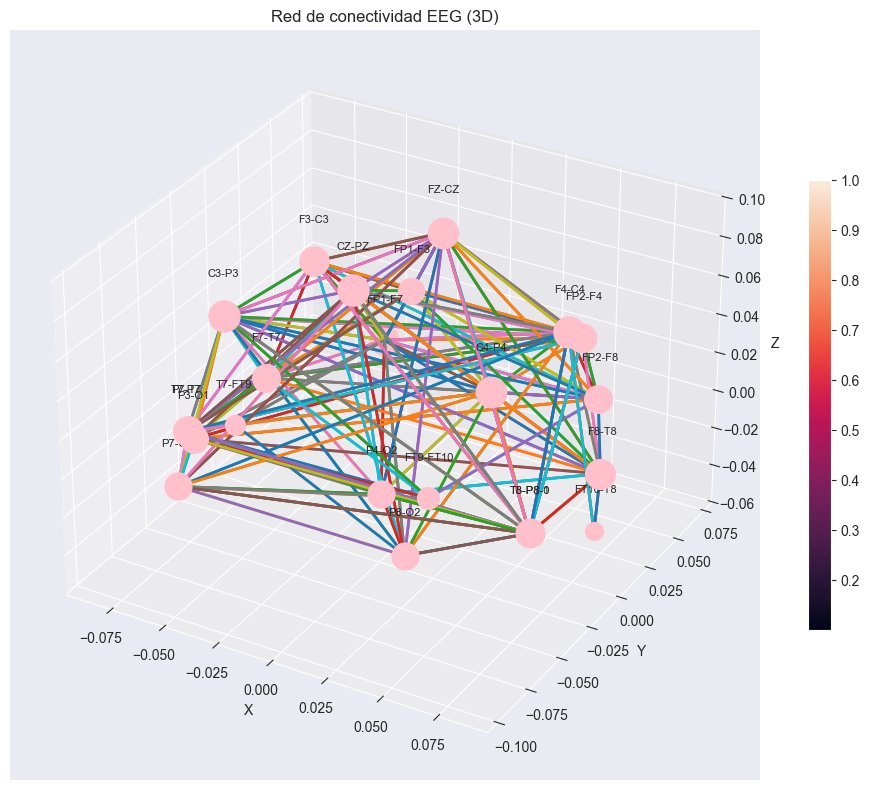

In [10]:
grafo = nx.from_pandas_adjacency(corr_df>0.1 , create_using=nx.DiGraph)
G = grafo.to_undirected() # Hay que convertir el grafo a no direccionado para los cálculos

montage = mne.channels.make_standard_montage('standard_1020')
# normalizar nombres del montage a mayúsculas
pos = {k.upper(): v for k, v in montage.get_positions()['ch_pos'].items()}

pos3D = {}
for canal in ch_names:
    partes = canal.split('-')
    elec1, elec2 = partes[0], partes[1]  # solo los dos primeros
    if elec1 in pos and elec2 in pos:
        x = (pos[elec1][0] + pos[elec2][0]) / 2
        y = (pos[elec1][1] + pos[elec2][1]) / 2
        z = (pos[elec1][2] + pos[elec2][2]) / 2
        pos3D[canal] = (x, y, z)
    else:
        print(f"Electrodo no encontrado: {elec1} o {elec2}")

# ===========================
# Grafo ponderado con PLV
# ===========================
# Usar valores reales de PLV para pesos
G = nx.from_pandas_adjacency(corr_df, create_using=nx.DiGraph)
# Filtrar aristas débiles
G = nx.DiGraph([(i,j,d) for i,j,d in G.edges(data=True) if d['weight']>0.1])

# ===========================
# Escalar nodos según grado
# ===========================
degree_dict = dict(G.degree())
max_degree= max(degree_dict.values()) if degree_dict else 1

exponente=2

# ===========================
# Configurar colormap para aristas
# ===========================
weights = [d['weight'] for _,_,d in G.edges(data=True)]
if weights:
    norm = plt.Normalize(min(weights), max(weights))

# ===========================
# Grafo 3D
# ===========================
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Dibujar nodos
for canal, (x, y, z) in pos3D.items():
    size = 100 + 400*degree_dict.get(canal,0)/max(degree_dict.values())
    ax.scatter(x, y, z, s=size, color='pink')
    ax.text(x, y, z+0.02, canal, fontsize=8, ha='center')

#
node_sizes={n:100+1000*(degree_dict.get(n,0)/max_degree)**exponente for n in G.nodes()}

# Dibujar aristas coloreadas según PLV
for i, j, data in G.edges(data=True):
    if i in pos3D and j in pos3D:
        x = [pos3D[i][0], pos3D[j][0]]
        y = [pos3D[i][1], pos3D[j][1]]
        z = [pos3D[i][2], pos3D[j][2]]
        ax.plot(x, y, z,  linewidth=2)

# Colorbar para PLV
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)

# Ejes y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Red de conectividad EEG (3D)')

plt.tight_layout()
plt.show()

In [ ]:
degree_dict = dict(G.degree())
max_degree = max(degree_dict.values()) if degree_dict else 1

# Aumenta este exponente para hacer los hubs aún más grandes
exponente_escala = 2

# Modificación aquí: eleva el grado normalizado a una potencia
node_sizes = {n: 100 + 1000 * (degree_dict.get(n, 0) / max_degree)**exponente_escala for n in G.nodes()}

# ===========================
# Grafo 3D
# ===========================
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Dibujar nodos
for canal, (x, y, z) in pos3D.items():
    # Usar el diccionario de tamaños precalculado
    size = node_sizes.get(canal, 50) # 50 es un tamaño por defecto si el nodo no está en el grafo
    ax.scatter(x, y, z, s=size, color='pink')
    ax.text(x, y, z+0.02, canal, fontsize=8, ha='center')